# Imports

In [2]:
import numpy as np
import pandas as pd
import os
import time
import random
import gc
eps = np.finfo(float).eps
from PIL import Image
#os.chdir('C:\\Users\\High Performance PC\\Desktop\\Code for Fly eyes\\Machine learning\\Gaurav data-20210324T012725Z-002\\Gaurav data')
from os.path import dirname, join as pjoin
import scipy.io as sio

In [3]:
#Import at the beginning even though we use it later.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cv2 

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

#This is important-- Anti_aliasing seems to affect results. Since we run this twice, name it:
aabool = False  #anti_aliasing=False

In [15]:
os.getcwd ()

'G:\\.shortcut-targets-by-id\\1mxikWlMW-yIeTUrdf00_CyHRMmuxNxii\\B207\\LabData\\Xiaojing\\04_PANI_PolarCam\\SLM_CCD_PAX_recon\\pyrecon'

# Functions

In [4]:
def myplot2D(A):
    dim = A.shape[0]
    # plt.pcolormesh(A) 
    plt.imshow(A)
    # plt.axis('equal')
    # plt.axis('off')
    plt.colorbar()
    plt.show()
    
def mysubplot(a, b, Data, offset, step, title, climt = None):
    fig = plt.figure(figsize=(b*3,a*3), )
#     plt.subplots_adjust(hspace=0.5)
#     plt.suptitle(title,fontsize=18)
    c=1
    for i in range(a*b):
        fig, ax = plt.subplot(a, b, c)
#         fig.tight_layout()
        # plt.title('{}, subplot: {}{}{}'.format(i, a, b, c))
        if climt == None:
            im = ax.imshow(Data[offset+i*step,:,:])
        else:
            im = ax.imshow(Data[offset+i*step,:,:],  vmin=-climt, vmax=climt) #cmap = 'coolwarm', 'bwr_r',
        ax.axis('off')
        
        c = c + 1
#         # create an axes on the right side of ax. The width of cax will be 5%
#         # of ax and the padding between cax and ax will be fixed at 0.05 inch.
#         divider = make_axes_locatable(ax)
#         cax = divider.append_axes("right", size="5%", pad=0.05)
#         plt.colorbar(im, cax=cax)
        plt.axis('equal')
    plt.show()    

In [5]:
def find_ssims(x1,x2):
    x1[x1>1] = 1
    x1[x1<-1] = -1
    x2[x2>1] = 1
    x2[x2<-1] = -1 
    length=np.shape(x1)[0]
    ss=[]
    for i in range(length):
        ss.append(ssim(x1[i],x2[i]))
    return ss

def find_mses(x1,x2):
    x1[x1>1] = 1
    x1[x1<-1] = -1
    x2[x2>1] = 1
    x2[x2<-1] = -1
    
    length=np.shape(x1)[0]
    ss=[]
    for i in range(length):
        ss.append(mean_squared_error(x1[i],x2[i]))
    return ss

def find_ms_ssims(x1,x2):
    x1[x1>1] = 1
    x1[x1<-1] = -1
    x2[x2>1] = 1
    x2[x2<-1] = -1
    x1 = x1+1
    x2 = x2+1
    
    length=np.shape(x1)[0]
    msss=[]
    for i in range(length):
#         print(x1[i].shape)
        x1_temp = cv2.merge([x1[i],x1[i],x1[i]])
        x2_temp = cv2.merge([x2[i],x2[i],x2[i]])
        msss.append(tf.image.ssim_multiscale(x1_temp,x2_temp, max_val = 2))
    return msss

In [6]:
def listToQuad(data):
    n0 = data.shape[0]

    d = data.shape[1]//4
    c = int(np.sqrt(d))
    topLeft = data[:, 0:d].reshape([n0,c,c])
    topRight = data[:, d:2*d].reshape([n0,c,c])
    bottomLeft = data[:, 2*d:3*d].reshape([n0,c,c])
    bottomRight = data[:, 3*d:4*d].reshape([n0,c,c])

    (cX, cY) = (c, c)
    (w, h) = (cX*2, cY*2)
    
    image = np.zeros((n0,w,h))
    # merge 4 images into one
    # top left, top right, bottom left, and bottom right.
    image[:,0:cY, 0:cX] = topLeft
    image[:,0:cY, cX:w] = topRight
    image[:,cY:h, 0:cX] = bottomLeft
    image[:,cY:h, cX:w] = bottomRight
    
    return image

In [7]:
def prediction_evalutaion(model, X_train, Y_train, L, imfashi_norm,imdigit_norm,imcifar_norm, imvortx_norm, 
                          stokes_fashi,stokes_digit,stokes_cifar, climt):
#     Nselect = X_train.shape[1]
#     Pred_ci = np.transpose (A @ np.transpose(imcifar_norm[:, L]))
#     Pred_fa = np.transpose( A @ np.transpose(imfashi_norm[:, L]))
#     Pred_di = np.transpose( A @ np.transpose(imdigit_norm[:, L]))
#     Pred_vo = np.transpose (A @ np.transpose(imvortx_norm[:, L]))
    
    Pred_fa = model.predict(imfashi_norm[:, L])
    Pred_di = model.predict(imdigit_norm[:, L])
    Pred_ci = model.predict(imcifar_norm[:, L])
    Pred_vo = model.predict(imvortx_norm[:, L])  
    
    pred_ci = listToQuad(Pred_ci)
    pred_fa = listToQuad(Pred_fa)
    pred_di = listToQuad(Pred_di)
    pred_vo = listToQuad(Pred_vo)

    target_stokes_ci = listToQuad(stokes_cifar)
    target_stokes_fa = listToQuad(stokes_fashi)
    target_stokes_di = listToQuad(stokes_digit)


#     Nim = 6
#     offset = 10
#     mysubplot(1,Nim,pred_fa,offset,100, "Fashion Predict Image",climt)
#     mysubplot(1,Nim,target_stokes_fa, offset,100, "Fashion Target Image",climt)
#     offset = 30
#     mysubplot(1,Nim,pred_di,offset,100, "Digital Predict Image",climt)
#     mysubplot(1,Nim,target_stokes_di, offset,100, "Digital Target Image",climt)
#     offset = 40
#     mysubplot(1,Nim,pred_ci,offset,500, "Cifar Predict Image",climt)
#     mysubplot(1,Nim,target_stokes_ci, offset,500, "Cifar Target Image",climt)
#     offset = 0
#     mysubplot(1,Nim,pred_vo,offset, 1, "Vortex Predict Image",climt)

#     print(pred_fa.shape,target_stokes_fa.shape)
    cif_ss=find_ssims(pred_ci,target_stokes_ci)
    fas_ss=find_ssims(pred_fa,target_stokes_fa)
    dig_ss=find_ssims(pred_di,target_stokes_di)

    cif_ms=find_mses(pred_ci,target_stokes_ci)
    fas_ms=find_mses(pred_fa,target_stokes_fa)
    dig_ms=find_mses(pred_di,target_stokes_di)

    
#     fas_msss=find_ms_ssims(pred_fa,target_stokes_fa)
#     dig_msss=find_ms_ssims(pred_di,target_stokes_di)
#     cif_msss=find_ms_ssims(pred_ci,target_stokes_ci)

    print("SSIM of cifar, fashion, mnist:{0:.3f},{1:.3f},{2:.3f}".format(np.mean(cif_ss), np.mean(fas_ss), np.mean(dig_ss)))
    print("MSE of cifar, fashion, mnist:{0:.3f},{1:.3f},{2:.3f}".format(np.mean(cif_ms), np.mean(fas_ms), np.mean(dig_ms)))
    
    dssim = np.array([np.mean(cif_ss), np.mean(fas_ss), np.mean(dig_ss)])
    dmse = np.array([np.mean(cif_ms), np.mean(fas_ms), np.mean(dig_ms)])
#     dmsssim = np.array([np.mean(cif_msss), np.mean(fas_msss), np.mean(dig_msss)])
    
    return dssim, dmse

In [8]:
def plot_ssim_mse(fas_ssim, dig_ssim, ci_ssim, fas_mse, dig_mse, cif_mse):
    plt.plot(fas_ssim, 'o', label = 'fashi')
    plt.plot(dig_ssim, 'o', label = 'digit')
    plt.plot(cif_ssim, 'o', label = 'cifar')
    plt.title('SSIM')
    plt.legend()
    plt.show()

    plt.plot(fas_mse, 'o', label = 'fashi')
    plt.plot(dig_mse, 'o', label = 'digit')
    plt.plot(cif_mse, 'o', label = 'cifar')
    plt.title('MSE')
    plt.legend()
    plt.show()

# Params

In [9]:
cats = ['LCP','RCP','P45','N45','V90','H0']
slmfns = ['PolarSLMWP_LCP_78.2_76','PolarSLMWP_RCP_33.2_76', 'P45','N45', 'V90', 'H0']
polarids = np.array([0, 1500, 3000, 4500, 6000, 7500])
(LCPid, RCPid, P45id, N45id, V90id, H0id) = (0, 1500, 3000, 4500, 6000, 7500) 

# Method:  Psuedo inverse with DownSize data

In [10]:
# path = r"G:\My Drive\B207\LabData\Xiaojing\04_PANI_PolarCam\SLM_CCD_PAX_recon\pyrecon"
path = r"G:\.shortcut-targets-by-id\1mxikWlMW-yIeTUrdf00_CyHRMmuxNxii\B207\LabData\Xiaojing\04_PANI_PolarCam\SLM_CCD_PAX_recon\pyrecon"
# Load Y
Ystoke = np.load(pjoin(path,'datas/disorder/Ytarget_0_1.npz'))

# Load X
Xtrain = np.load(pjoin(path,'datas/disorder/Xtrain_dwsz.npz'))# '_stdrand', '_rand'
Xtest  = np.load(pjoin(path,'datas/disorder/Xtest_dwsz.npz'))
print(Ystoke.files, Xtrain.files, Xtest.files)

print(Xtrain['tr_img_cifar'].shape, np.max(Xtrain['tr_img_cifar']))
print(Xtest['img_cifar'].shape, np.max(Xtest['img_cifar']))

maxvalue = 255
Npoints = Xtest['img_cifar'].shape[2]
tr_imcifar_norm = Xtrain['tr_img_cifar'].reshape((9000,Npoints))/maxvalue
imcifar_norm = Xtest['img_cifar'].reshape((3000,Npoints))/maxvalue
imfashi_norm = Xtest['img_fashi'].reshape((600,Npoints))/maxvalue
imdigit_norm = Xtest['img_digit'].reshape((600,Npoints))/maxvalue
imvortx_norm = Xtest['img_vortx'].reshape((18,Npoints))/maxvalue

print(imcifar_norm.shape, np.max(imdigit_norm), np.max(imfashi_norm), np.max(imcifar_norm))
# print(imfashi_norm.max(), imfashi_norm.min(), imcifar_norm.max(), imcifar_norm.min())

['tr_stokes_cifar', 'stokes_cifar', 'stokes_fashi', 'stokes_digit'] ['tr_img_cifar'] ['img_cifar', 'img_fashi', 'img_digit', 'img_vortx']
(6, 1500, 4096) 101
(6, 500, 4096) 101
(3000, 4096) 0.36470588235294116 0.3411764705882353 0.396078431372549


## Compare Result with different number of selected Points

In [11]:
Nselects = np.array([1024, 2048, 3072, 4096, 5120, 6144],  dtype=int)
print(Nselects)

[1024 2048 3072 4096 5120 6144]


In [11]:
As_dwsz = []

# for i in range(len(Ls)-2):
#     print(i)
#     X = tr_imcifar_norm[:, Ls[i]]

#     #Split to train and test and normalization
#     # X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)
#     X_train, Y_train = X, Y

#     x = np.transpose(X_train)
#     y = np.transpose(Y_train)
#     A = y @ np.linalg.pinv(x)
#     print(X_train.shape, Y_train.shape, x.shape, y.shape, A.shape)
#     As_dwsz.append(A)
    
#     dssim, dmse = prediction_evalutaion(As_dwsz[i],
#                                                  X_train,
#                                                  Y_train, 
#                                                  Ls[i],
#                                                  imfashi_norm,
#                                                  imdigit_norm,
#                                                  imcifar_norm,
#                                                  imvortx_norm,
#                                                  Ystoke['stokes_fashi'],
#                                                  Ystoke['stokes_digit'],
#                                                  Ystoke['stokes_cifar'],
#                                                  climt = 1)

#     dssims.append(dssim)
#     dmses.append(dmse)

# Stdrand

In [12]:
Xtrain = np.load('datas/disorder/Xtrain_stdrand.npz') # '_stdrand', '_rand'
Xtest  = np.load('datas/disorder/Xtest_stdrand.npz')
print(Xtrain['tr_img_cifar'].shape, np.max(Xtrain['tr_img_cifar']))
print(Xtest['img_cifar'].shape, np.max(Xtest['img_cifar']))

maxvalue = 255
Npoints = 7000
tr_imcifar_norm = Xtrain['tr_img_cifar'].reshape((9000,Npoints))/maxvalue
imcifar_norm = Xtest['img_cifar'].reshape((3000,Npoints))/maxvalue
imfashi_norm = Xtest['img_fashi'].reshape((600,Npoints))/maxvalue
imdigit_norm = Xtest['img_digit'].reshape((600,Npoints))/maxvalue
imvortx_norm = Xtest['img_vortx'].reshape((18,Npoints))/maxvalue

imcifar_norm.shape, np.max(imdigit_norm), np.max(imfashi_norm), np.max(imcifar_norm)

(6, 1500, 7000) 139
(6, 500, 7000) 164


((3000, 7000), 0.4745098039215686, 0.47843137254901963, 0.6431372549019608)

In [13]:
def model_1L_a(hidden_nets, input_dim):
    model = Sequential()
    model.add(Dense(hidden_nets, input_shape=(input_dim,), kernel_initializer='normal', activation='linear'))
    model.add(Dropout(0.1))
    model.add(Dense(4096, kernel_initializer='normal', activation='tanh')) # output node
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=['mae'])
    print(model.summary())
    return model

In [14]:
Nselects = np.array([1024, 2048, 3072, 4096, 5120, 6144],  dtype=int)

Ls = []
for i in range (5):
    for Nselect in Nselects:
        L = random.sample(range(0,7000), Nselect)
        Ls.append(L)

In [15]:
hidden_net = 5000

dssims = []    #####
dmses = []
historys = []

EPS = 1000
BTSZ = 2000

# EPS = 2
# BTSZ = 2000

In [16]:
# build multiple models
models_stdhi = list()
for k in range(5):
    for i in range(len(Nselects)):
        models_stdhi.append(model_1L_a(hidden_net, Nselects[i]))

# training the models, and return ssim, mse
Y = Ystoke['tr_stokes_cifar']
for i in range(len(Ls)):
    X = tr_imcifar_norm[:, Ls[i]]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.01)
    print(X_train.shape, Y_train.shape)
    
    history = models_stdhi[i].fit(X_train,Y_train,validation_split = 0.1, epochs =EPS, batch_size = BTSZ,shuffle=True,verbose=0)
    historys.append(history)
    
    dssim, dmse = prediction_evalutaion(models_stdhi[i],
                                         X_train,
                                         Y_train, 
                                         Ls[i],
                                         imfashi_norm,
                                         imdigit_norm,
                                         imcifar_norm,
                                         imvortx_norm,
                                         Ystoke['stokes_fashi'],
                                         Ystoke['stokes_digit'],
                                         Ystoke['stokes_cifar'],
                                         climt = 1)
    dssims.append(dssim)
    dmses.append(dmse)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5000)              5125000   
_________________________________________________________________
dropout (Dropout)            (None, 5000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              20484096  
Total params: 25,609,096
Trainable params: 25,609,096
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense) 

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 5000)              5125000   
_________________________________________________________________
dropout_12 (Dropout)         (None, 5000)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 4096)              20484096  
Total params: 25,609,096
Trainable params: 25,609,096
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 5000)              10245000  
_________________________________________________________________
dropout_13 (Dropout)         (None, 5000)              0         
_____________

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 5000)              5125000   
_________________________________________________________________
dropout_24 (Dropout)         (None, 5000)              0         
_________________________________________________________________
dense_49 (Dense)             (None, 4096)              20484096  
Total params: 25,609,096
Trainable params: 25,609,096
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 5000)              10245000  
_________________________________________________________________
dropout_25 (Dropout)         (None, 5000)              0         
_____________

# rand

In [17]:
Xtrain = np.load('datas/disorder/Xtrain_rand.npz') # '_stdrand', '_rand'
Xtest  = np.load('datas/disorder/Xtest_rand.npz')
print(Xtrain['tr_img_cifar'].shape, np.max(Xtrain['tr_img_cifar']))
print(Xtest['img_cifar'].shape, np.max(Xtest['img_cifar']))

maxvalue = 255
Npoints = Xtest['img_cifar'].shape[2]
tr_imcifar_norm = Xtrain['tr_img_cifar'].reshape((9000,Npoints))/maxvalue
imcifar_norm = Xtest['img_cifar'].reshape((3000,Npoints))/maxvalue
imfashi_norm = Xtest['img_fashi'].reshape((600,Npoints))/maxvalue
imdigit_norm = Xtest['img_digit'].reshape((600,Npoints))/maxvalue
imvortx_norm = Xtest['img_vortx'].reshape((18,Npoints))/maxvalue

imcifar_norm.shape, np.max(imdigit_norm), np.max(imfashi_norm), np.max(imcifar_norm)

(6, 1500, 8000) 107
(6, 500, 8000) 103


((3000, 8000), 0.3764705882352941, 0.3254901960784314, 0.403921568627451)

In [18]:
# build multiple models
models_rand = list()
for k in range(5):
    for i in range(len(Nselects)):
        models_rand.append(model_1L_a(hidden_net, Nselects[i]))

Y = Ystoke['tr_stokes_cifar']
for i in range(len(Ls)):
    X = tr_imcifar_norm[:, Ls[i]]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.01)
    print(X_train.shape, Y_train.shape)
    
    history = models_rand[i].fit(X_train,Y_train,validation_split = 0.1, epochs =EPS, batch_size = BTSZ,shuffle=True,verbose=0)
    historys.append(history)
    
    dssim, dmse = prediction_evalutaion(models_rand[i],
                                         X_train,
                                         Y_train, 
                                         Ls[i],
                                         imfashi_norm,
                                         imdigit_norm,
                                         imcifar_norm,
                                         imvortx_norm,
                                         Ystoke['stokes_fashi'],
                                         Ystoke['stokes_digit'],
                                         Ystoke['stokes_cifar'],
                                         climt = 1)
    dssims.append(dssim)
    dmses.append(dmse)

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 5000)              5125000   
_________________________________________________________________
dropout_30 (Dropout)         (None, 5000)              0         
_________________________________________________________________
dense_61 (Dense)             (None, 4096)              20484096  
Total params: 25,609,096
Trainable params: 25,609,096
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 5000)              10245000  
_________________________________________________________________
dropout_31 (Dropout)         (None, 5000)              0         
_____________

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_86 (Dense)             (None, 5000)              10245000  
_________________________________________________________________
dropout_43 (Dropout)         (None, 5000)              0         
_________________________________________________________________
dense_87 (Dense)             (None, 4096)              20484096  
Total params: 30,729,096
Trainable params: 30,729,096
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 5000)              15365000  
_________________________________________________________________
dropout_44 (Dropout)         (None, 5000)              0         
_____________

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_110 (Dense)            (None, 5000)              10245000  
_________________________________________________________________
dropout_55 (Dropout)         (None, 5000)              0         
_________________________________________________________________
dense_111 (Dense)            (None, 4096)              20484096  
Total params: 30,729,096
Trainable params: 30,729,096
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_112 (Dense)            (None, 5000)              15365000  
_________________________________________________________________
dropout_56 (Dropout)         (None, 5000)              0         
_____________

## Plot results

In [13]:
dssims_mean = np.mean(np.asarray(dssims), axis=1)
dmses_mean = np.mean(np.asarray(dmses), axis=1)
# dssims, dmses, dssims_mean, dmses_mean

NameError: name 'dssims' is not defined

In [23]:
dssims_mean1 = dssims_mean.reshape(2,5,6)
dssims_mean2 = np.mean(dssims_mean1, axis=1)
errmin = np.min(dssims_mean1, axis = 1)-dssims_mean2
errmax = np.max(dssims_mean1, axis = 1)-dssims_mean2
dssims_mean,dssims_mean.reshape(2,5,6), dssims_mean2.shape, errmin, errmax

dmses_mean1 = dmses_mean.reshape(2,5,6)
dmses_mean2 = np.mean(dmses_mean1, axis=1)
errmin_mse = np.min(dmses_mean1, axis = 1)-dmses_mean2
errmax_mse = np.max(dmses_mean1, axis = 1)-dmses_mean2
errmin_mse,

(array([[-0.00152811, -0.00548607, -0.00258183, -0.00209445, -0.00277442,
         -0.00411173],
        [-0.00256546, -0.00206686, -0.00184478, -0.00161636, -0.00269478,
         -0.00335667]]),)

In [25]:
# Import required packages
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pylab import cm
import matplotlib.font_manager as fm

# Collect all the font names available to matplotlib
font_names = [f.name for f in fm.fontManager.ttflist]
# print(font_names)

# Edit the font, font size, and axes width
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

# Generate 2 colors from the 'Set1' colormap
colors = cm.get_cmap('Paired')

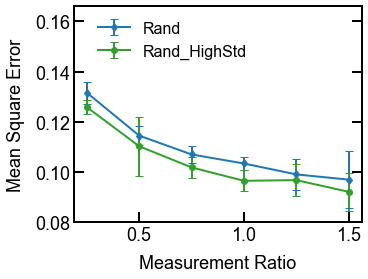

In [29]:
# Create figure object and store it in a variable called 'fig'
fig = plt.figure(figsize=(4, 3))

# Add axes object to our figure that takes up entire figure
ax = fig.add_axes([0, 0, 1, 1])

# Edit the major and minor ticks of the x and y axes
ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in')
ax.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in')
ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=2, direction='in', right='on')


# Plot the two sample absorbances, using previously generated colors
# ax.plot(Nselects/4096, dmses_mean[0:6], '-o',linewidth=2, color=colors(3), label='Rand_HighStd')
# ax.plot(Nselects/4096, dmses_mean[6:12],'-o', linewidth=2, color=colors(1), label='Rand')

x = Nselects/4096
y_err = errmax_mse - errmin_mse
# ax.plot(x, dmses_mean2[1,:],'-d', linewidth=2, color=colors(1), label='Rand')
ax.errorbar(x, dmses_mean2[1,:], yerr = y_err[1,:], capsize = 4, linewidth=2, color=colors(1), fmt ='-d', label='Rand')
# ax.plot(x, dmses_mean2[0,:], '-d',linewidth=2, color=colors(3), label='Rand_HighStd')
ax.errorbar(x, dmses_mean2[0,:], yerr = y_err[0,:], capsize = 4, linewidth=2, color=colors(3),fmt ='-o',label='Rand_HighStd')

# # Edit the major and minor tick locations of x and y axes
# ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1000))
# ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(50))
# ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
# ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))

# Add the x and y-axis labels
# ax.set_xlabel(r'$\mathregular{\lambda}$ (nm)', labelpad=10) measurement rates
ax.set_xlabel(r'Measurement Ratio', labelpad=10) # undersampling rate, compression rate
ax.set_ylabel('Mean Square Error', labelpad=10)

# # Set the axis limits
# ax.set_xlim(370, 930)
# ax.set_ylim(-0.2, 2.2)
ax.set_ylim(0.08, 0.166)

# Add legend to plot
ax.legend(bbox_to_anchor=(0.65, 1), loc=1, frameon=False, fontsize=16)

# Save figure
plt.savefig('MSEx55_NN.svg', dpi=300, transparent=True, bbox_inches='tight')

# Show figure
plt.show()

In [59]:
np.savez(pjoin(path,'NNresult2_disorder_nets5000x5.npz'), 
         Nselects = Nselects,
         dssims_mean = dssims_mean, 
         dmses_mean = dmses_mean)

In [60]:
np.savez(pjoin(path,'NNx5_MSE_disorder.npz'), 
         Nselects = Nselects,
         dssims_mean = dssims_mean, 
         dmses_mean = dmses_mean)

## len(historys)

In [52]:
import pickle
for i in range(len(historys)):
# for i in range(1):
    pd.DataFrame
    hist_df = pd.DataFrame(historys[i].history)
    hist_df.to_csv('historys/NNx5_historys'+str(i)+'.csv', index=False)

In [50]:
import pandas as pd
df = pd.read_csv('NNx5_historys0.csv', index_col = 0)
df

,loss,mean_absolute_error,val_loss,val_mean_absolute_error
0,0.341351,0.470893,0.267157,0.413980
1,0.261972,0.408979,0.235262,0.383106
2,0.234142,0.380122,0.215780,0.359101
3,0.214748,0.358201,0.198241,0.342164
4,0.195230,0.339957,0.183020,0.327898
...,...,...,...,...
995,0.072349,0.203172,0.089487,0.223767
996,0.073023,0.204113,0.087017,0.220780
997,0.071937,0.202590,0.086777,0.220063
998,0.071561,0.201872,0.086549,0.220185


In [16]:
import pickle
with open("NNx5_Ls", "wb") as fp:   #Pickling
    pickle.dump(Ls, fp)

In [57]:
for i in range(len(models_stdhi)):
# for i in range(1):
    models_stdhi[i].save('NNmodels/models_stdhi{}'.format(i))
    
for i in range(len(models_rand)):
    models_rand[i].save('NNmodels/models_rand{}'.format(i))

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


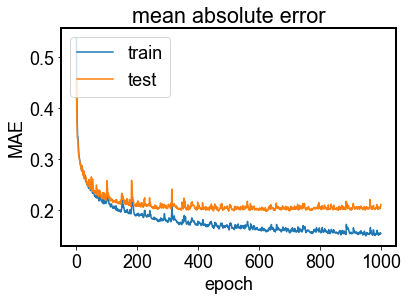

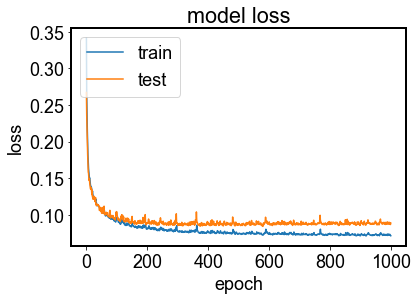

In [39]:
print(historys[0].history.keys())
# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('mean absolute error')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(historys[0].history['loss'])
plt.plot(historys[0].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


## Plot images

In [25]:
# os.path.dirname(__file__)
os.path.dirname(os.path.abspath("__file__"))

'G:\\My Drive\\B207\\LabData\\Xiaojing\\04_PANI_PolarCam\\SLM_CCD_PAX_recon\\pyrecon'

In [26]:
def mysubplot(a, b, Data, offset, step, title, climt = None):
    fig = plt.figure(figsize=(b*3,a*3),) 
#     plt.subplots_adjust(hspace=0.05)
    plt.subplots_adjust(wspace=0.1)
#     plt.suptitle(title,fontsize=18)
    c=1
    for i in range(a*b):
        ax = plt.subplot(a, b, c)
        # plt.title('{}, subplot: {}{}{}'.format(i, a, b, c))
        if climt == None:
            im = ax.imshow(Data[offset+i*step,:,:])
        else:
            im = ax.imshow(Data[offset+i*step,:,:],  vmin=-climt, vmax=climt) #cmap = 'coolwarm', 'bwr_r',
        ax.axis('off')
        
        c = c + 1
#         # create an axes on the right side of ax. The width of cax will be 5%
#         # of ax and the padding between cax and ax will be fixed at 0.05 inch.
#         divider = make_axes_locatable(ax)
#         cax = divider.append_axes("right", size="5%", pad=0.05)
#         plt.colorbar(im, cax=cax)
        plt.axis('equal')
    plt.savefig(pjoin(path,title+'.svg'), dpi=300, transparent=True, bbox_inches='tight')
    plt.show()

In [27]:
Xtrain = np.load(pjoin(path,'datas/disorder/Xtrain_stdrand.npz')) # '_stdrand', '_rand'
Xtest  = np.load(pjoin(path,'datas/disorder/Xtest_stdrand.npz'))
print(Xtrain['tr_img_cifar'].shape, np.max(Xtrain['tr_img_cifar']))
print(Xtest['img_cifar'].shape, np.max(Xtest['img_cifar']))

maxvalue = 255
Npoints = Xtest['img_cifar'].shape[2]
tr_imcifar_norm = Xtrain['tr_img_cifar'].reshape((9000,Npoints))/maxvalue
imcifar_norm = Xtest['img_cifar'].reshape((3000,Npoints))/maxvalue
imfashi_norm = Xtest['img_fashi'].reshape((600,Npoints))/maxvalue
imdigit_norm = Xtest['img_digit'].reshape((600,Npoints))/maxvalue
imvortx_norm = Xtest['img_vortx'].reshape((18,Npoints))/maxvalue

imcifar_norm.shape, np.max(imdigit_norm), np.max(imfashi_norm), np.max(imcifar_norm)

(6, 1500, 7000) 139
(6, 500, 7000) 164


((3000, 7000), 0.4745098039215686, 0.47843137254901963, 0.6431372549019608)

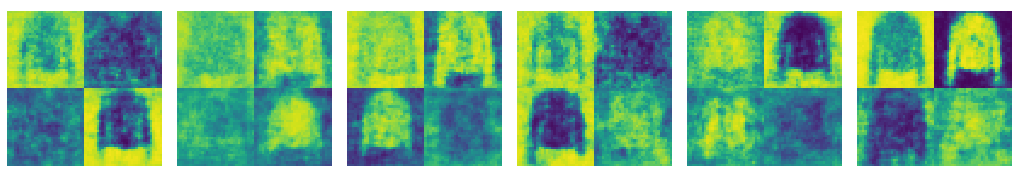

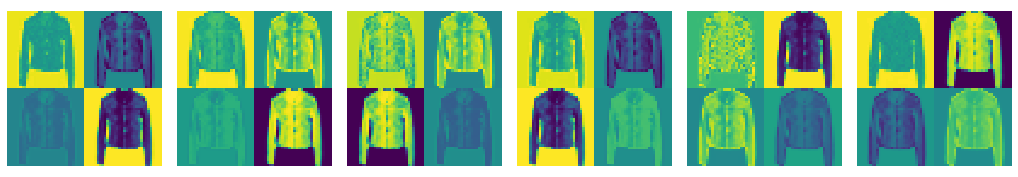

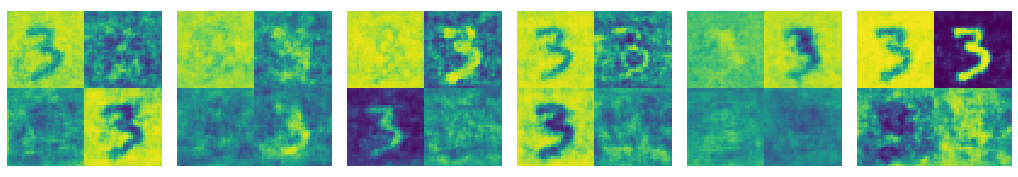

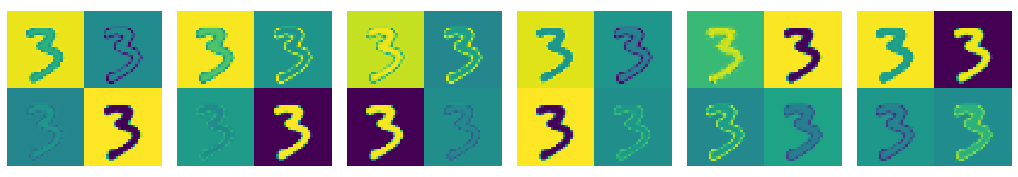

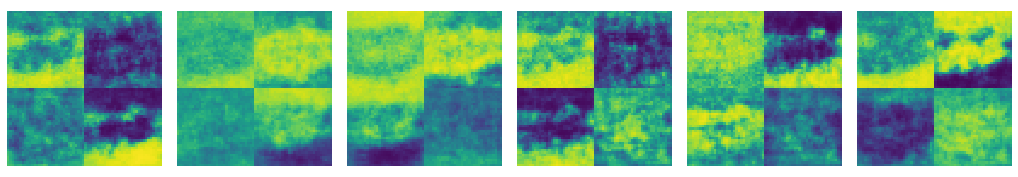

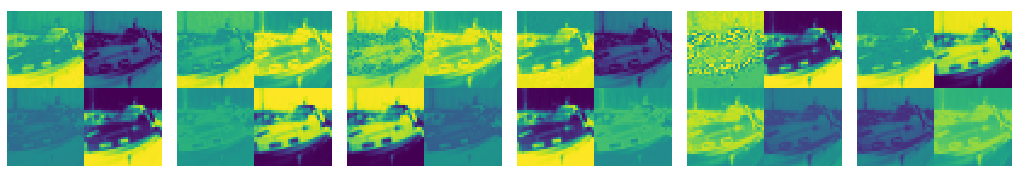

SSIM of cifar, fashion, mnist:0.383,0.331,0.315
MSE of cifar, fashion, mnist:0.073,0.101,0.114
[0.38316505 0.33000998 0.31225735]
[0.07296269 0.10073218 0.11474704]


In [28]:
climt = 1
# idx = [0, 1, 2, 3, 4, 5]
idx = [ 4]
for i in idx:
    model = models_stdhi[i]
    Pred_fa = model.predict(imfashi_norm[:, Ls[i]])
    Pred_di = model.predict(imdigit_norm[:, Ls[i]])
    Pred_ci = model.predict(imcifar_norm[:, Ls[i]])
    Pred_vo = model.predict(imvortx_norm[:, Ls[i]])  
    
    pred_ci = listToQuad(Pred_ci)
    pred_fa = listToQuad(Pred_fa)
    pred_di = listToQuad(Pred_di)
    pred_vo = listToQuad(Pred_vo)

    target_stokes_ci = listToQuad(Ystoke['stokes_cifar'])
    target_stokes_fa = listToQuad(Ystoke['stokes_fashi'])
    target_stokes_di = listToQuad(Ystoke['stokes_digit'])


    Nim = 6
    offset = 10
    mysubplot(1,Nim,pred_fa,offset,100, "Fashion Predict Image",climt)
    mysubplot(1,Nim,target_stokes_fa, offset,100, "Fashion Target Image",climt)
    offset = 30
    mysubplot(1,Nim,pred_di,offset,100, "Digital Predict Image",climt)
    mysubplot(1,Nim,target_stokes_di, offset,100, "Digital Target Image",climt)
    
    offset = 2
    mysubplot(1,Nim,pred_ci,offset,500, "Cifar Predict Image",climt)
    mysubplot(1,Nim,target_stokes_ci, offset,500, "Cifar Target Image",climt)

#     offset = 0
#     mysubplot(1,Nim,pred_vo,offset, 1, "Vortex Predict Image",climt)

    cif_ss=find_ssims(pred_ci,target_stokes_ci)
    fas_ss=find_ssims(pred_fa,target_stokes_fa)
    dig_ss=find_ssims(pred_di,target_stokes_di)

    cif_ms=find_mses(pred_ci,target_stokes_ci)
    fas_ms=find_mses(pred_fa,target_stokes_fa)
    dig_ms=find_mses(pred_di,target_stokes_di)

    print("SSIM of cifar, fashion, mnist:{0:.3f},{1:.3f},{2:.3f}".format(np.mean(cif_ss), np.mean(fas_ss), np.mean(dig_ss)))
    print("MSE of cifar, fashion, mnist:{0:.3f},{1:.3f},{2:.3f}".format(np.mean(cif_ms), np.mean(fas_ms), np.mean(dig_ms)))
    
    print(dssims[6+i])
    print(dmses[6+i])

# Verification

In [39]:
def prediction_evalutaion_stokes(model, L, imfashi_norm,imdigit_norm,imcifar_norm,
                          stokes_fashi,stokes_digit, stokes_cifar):
#     Nselect = X_train.shape[1]
#     Pred_ci = np.transpose (A @ np.transpose(imcifar_norm[:, L]))
#     Pred_fa = np.transpose( A @ np.transpose(imfashi_norm[:, L]))
#     Pred_di = np.transpose( A @ np.transpose(imdigit_norm[:, L]))
#     Pred_vo = np.transpose (A @ np.transpose(imvortx_norm[:, L]))
    
    Pred_fa = model.predict(imfashi_norm[:, L])
    Pred_di = model.predict(imdigit_norm[:, L])
    Pred_ci = model.predict(imcifar_norm[:, L])
    print (Pred_fa.shape, Pred_di.shape, Pred_ci.shape)
    
    pred_ci_s0 = Pred_ci[:, 0:1024].reshape([3000,32,32])
    pred_ci_s1 = Pred_ci[:, 1024:2048].reshape([3000,32,32])
    pred_ci_s2 = Pred_ci[:, 2048:3072].reshape([3000,32,32])
    pred_ci_s3 = Pred_ci[:, 3072:4096].reshape([3000,32,32])
    
    pred_fa_s0 = Pred_fa[:, 0:1024].reshape([600,32,32])
    pred_fa_s1 = Pred_fa[:, 1024:2048].reshape([600,32,32])
    pred_fa_s2 = Pred_fa[:, 2048:3072].reshape([600,32,32])
    pred_fa_s3 = Pred_fa[:, 3072:4096].reshape([600,32,32])
    
    pred_di_s0 = Pred_di[:, 0:1024].reshape([600,32,32])
    pred_di_s1 = Pred_di[:, 1024:2048].reshape([600,32,32])
    pred_di_s2 = Pred_di[:, 2048:3072].reshape([600,32,32])
    pred_di_s3 = Pred_di[:, 3072:4096].reshape([600,32,32])
    
    
    target_stokes_ci_s0 = stokes_cifar[:, 0:1024].reshape([3000,32,32])
    target_stokes_ci_s1 = stokes_cifar[:, 1024:2048].reshape([3000,32,32])
    target_stokes_ci_s2 = stokes_cifar[:, 2048:3072].reshape([3000,32,32])
    target_stokes_ci_s3 = stokes_cifar[:, 3072:4096].reshape([3000,32,32])
    
    target_stokes_fa_s0 = stokes_fashi[:, 0:1024].reshape([600,32,32])
    target_stokes_fa_s1 = stokes_fashi[:, 1024:2048].reshape([600,32,32])
    target_stokes_fa_s2 = stokes_fashi[:, 2048:3072].reshape([600,32,32])
    target_stokes_fa_s3 = stokes_fashi[:, 3072:4096].reshape([600,32,32])
    
    target_stokes_di_s0 = stokes_digit[:, 0:1024].reshape([600,32,32])
    target_stokes_di_s1 = stokes_digit[:, 1024:2048].reshape([600,32,32])
    target_stokes_di_s2 = stokes_digit[:, 2048:3072].reshape([600,32,32])
    target_stokes_di_s3 = stokes_digit[:, 3072:4096].reshape([600,32,32])

#     Nim = 6
#     offset = 10
#     mysubplot(1,Nim,pred_fa,offset,100, "Fashion Predict Image",climt)
#     mysubplot(1,Nim,target_stokes_fa, offset,100, "Fashion Target Image",climt)
#     offset = 30
#     mysubplot(1,Nim,pred_di,offset,100, "Digital Predict Image",climt)
#     mysubplot(1,Nim,target_stokes_di, offset,100, "Digital Target Image",climt)
#     offset = 40
#     mysubplot(1,Nim,pred_ci,offset,500, "Cifar Predict Image",climt)
#     mysubplot(1,Nim,target_stokes_ci, offset,500, "Cifar Target Image",climt)
#     offset = 0
#     mysubplot(1,Nim,pred_vo,offset, 1, "Vortex Predict Image",climt)

#     print(pred_fa.shape,target_stokes_fa.shape)

    cif_ms_s0=find_mses(pred_ci_s0,target_stokes_ci_s0)
    cif_ms_s1=find_mses(pred_ci_s1,target_stokes_ci_s1)
    cif_ms_s2=find_mses(pred_ci_s2,target_stokes_ci_s2)
    cif_ms_s3=find_mses(pred_ci_s3,target_stokes_ci_s3)
    
    fas_ms_s0=find_mses(pred_fa_s0,target_stokes_fa_s0)
    fas_ms_s1=find_mses(pred_fa_s1,target_stokes_fa_s1)
    fas_ms_s2=find_mses(pred_fa_s2,target_stokes_fa_s2)
    fas_ms_s3=find_mses(pred_fa_s3,target_stokes_fa_s3)
    
    dig_ms_s0=find_mses(pred_di_s0,target_stokes_di_s0)
    dig_ms_s1=find_mses(pred_di_s1,target_stokes_di_s1)
    dig_ms_s2=find_mses(pred_di_s2,target_stokes_di_s2)
    dig_ms_s3=find_mses(pred_di_s3,target_stokes_di_s3)
    
#     fas_msss=find_ms_ssims(pred_fa,target_stokes_fa)
#     dig_msss=find_ms_ssims(pred_di,target_stokes_di)
#     cif_msss=find_ms_ssims(pred_ci,target_stokes_ci)

    print("MSE of cifar s0, s1, s2, s3:{0:.3f},{1:.3f},{2:.3f},{3:.3f}".format(np.mean(cif_ms_s0), np.mean(cif_ms_s1), np.mean(cif_ms_s2),np.mean(cif_ms_s3)))
    print("MSE of fashion s0, s1, s2, s3:{0:.3f},{1:.3f},{2:.3f},{3:.3f}".format(np.mean(fas_ms_s0), np.mean(fas_ms_s1), np.mean(fas_ms_s2),np.mean(fas_ms_s3)))
    print("MSE of mnist s0, s1, s2, s3:{0:.3f},{1:.3f},{2:.3f},{3:.3f}".format(np.mean(dig_ms_s0), np.mean(dig_ms_s1), np.mean(dig_ms_s2),np.mean(dig_ms_s3)))
    
    dmse = np.array([[np.mean(cif_ms_s0), np.mean(cif_ms_s1), np.mean(cif_ms_s2),np.mean(cif_ms_s3)],
                    [np.mean(fas_ms_s0), np.mean(fas_ms_s1), np.mean(fas_ms_s2),np.mean(fas_ms_s3)],
                     [np.mean(dig_ms_s0), np.mean(dig_ms_s1), np.mean(dig_ms_s2),np.mean(dig_ms_s3)]])
#     dmsssim = np.array([np.mean(cif_msss), np.mean(fas_msss), np.mean(dig_msss)])
    
    return dmse

In [ ]:
import pickle
with open("disorderpublish/NNx5/NNx5_Ls", "rb") as fp:   # Unpickling
    Ls = pickle.load(fp)
Ls.shape

In [23]:
models_stdhi = []
for i in range(1):
    model_temp = tf.keras.models.load_model('disorderpublish/NNx5/NNmodels/models_stdhi{}'.format(i))
    model_temp.summary()
    models_stdhi.append(model_temp)

models_rand = []
for i in range(1):
    models_rand.append(tf.keras.models.load_model('disorderpublish/NNx5/NNmodels/models_rand{}'.format(i)))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5000)              5125000   
_________________________________________________________________
dropout (Dropout)            (None, 5000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              20484096  
Total params: 25,609,096
Trainable params: 25,609,096
Non-trainable params: 0
_________________________________________________________________


In [52]:
# Xtrain = np.load('datas/disorder/Xtrain_stdrand.npz') # '_stdrand', '_rand'
Xtest  = np.load('datas/disorder/Xtest_stdrand.npz')
print(Xtrain['tr_img_cifar'].shape, np.max(Xtrain['tr_img_cifar']))
print(Xtest['img_cifar'].shape, np.max(Xtest['img_cifar']))

maxvalue = 255
Npoints = 7000
# tr_imcifar_norm = Xtrain['tr_img_cifar'].reshape((9000,Npoints))/maxvalue
imcifar_norm = Xtest['img_cifar'].reshape((3000,Npoints))/maxvalue
imfashi_norm = Xtest['img_fashi'].reshape((600,Npoints))/maxvalue
imdigit_norm = Xtest['img_digit'].reshape((600,Npoints))/maxvalue
imvortx_norm = Xtest['img_vortx'].reshape((18,Npoints))/maxvalue

print(imcifar_norm.shape, np.max(imdigit_norm), np.max(imfashi_norm), np.max(imcifar_norm))

dmse_vec = []
for i in range(5):
    print(i, i*6+2)
    
    model_temp = tf.keras.models.load_model('disorderpublish/NNx5/NNmodels/models_stdhi{}'.format(i*6+2))
    dmse = prediction_evalutaion_stokes(model_temp,
    #                                      X_train,
    #                                      Y_train, 
                                         Ls[i*6+2],
                                         imfashi_norm,
                                         imdigit_norm,
                                         imcifar_norm,
    #                                      imvortx_norm,
                                         Ystoke['stokes_fashi'],
                                         Ystoke['stokes_digit'],
                                         Ystoke['stokes_cifar'],)
    dmse_vec.append(dmse)

(6, 1500, 7000) 139
(6, 500, 7000) 164
(3000, 7000) 0.4745098039215686 0.47843137254901963 0.6431372549019608
0 2
(600, 4096) (600, 4096) (3000, 4096)
MSE of cifar s0, s1, s2, s3:0.045,0.074,0.088,0.105
MSE of fashion s0, s1, s2, s3:0.044,0.096,0.129,0.168
MSE of mnist s0, s1, s2, s3:0.033,0.111,0.137,0.208
1 8
(600, 4096) (600, 4096) (3000, 4096)
MSE of cifar s0, s1, s2, s3:0.046,0.076,0.088,0.104
MSE of fashion s0, s1, s2, s3:0.047,0.099,0.121,0.172
MSE of mnist s0, s1, s2, s3:0.036,0.112,0.129,0.201
2 14
(600, 4096) (600, 4096) (3000, 4096)
MSE of cifar s0, s1, s2, s3:0.044,0.072,0.085,0.106
MSE of fashion s0, s1, s2, s3:0.046,0.095,0.110,0.170
MSE of mnist s0, s1, s2, s3:0.037,0.109,0.118,0.200
3 20
(600, 4096) (600, 4096) (3000, 4096)
MSE of cifar s0, s1, s2, s3:0.043,0.073,0.084,0.105
MSE of fashion s0, s1, s2, s3:0.045,0.097,0.116,0.166
MSE of mnist s0, s1, s2, s3:0.036,0.114,0.127,0.202
4 26
(600, 4096) (600, 4096) (3000, 4096)
MSE of cifar s0, s1, s2, s3:0.043,0.070,0.083,0.10

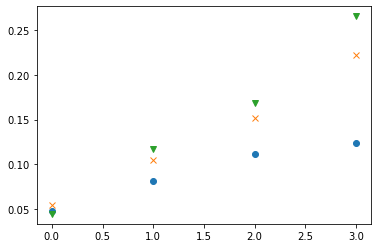

In [44]:
plt.plot(dmse[0], 'o')
plt.plot(dmse[1], 'x')
plt.plot(dmse[2], 'v')

In [53]:
np.asarray(dmse_vec).shape

(5, 3, 4)

((3, 4), (4,), array([0.04186913, 0.09356258, 0.1105552 , 0.16142815]))

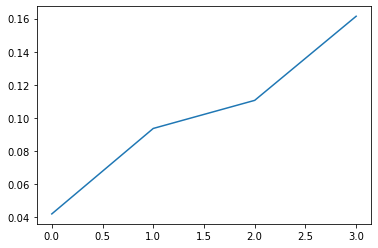

In [62]:
dmse_avgnn = np.mean(np.asarray(dmse_vec), axis = 0)
dmse_avgnn1 = np.mean(np.asarray(dmse_avgnn), axis = 0)
plt.plot(dmse_avgnn1)
dmse_avgnn.shape, dmse_avgnn1.shape, dmse_avgnn1

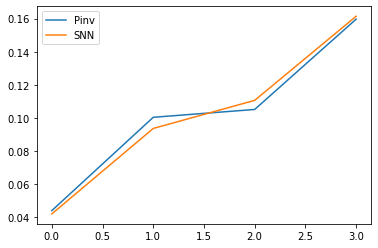

In [65]:
dms_avgPinv = np.array([0.04385401, 0.10030874, 0.10505041, 0.15966848])
plt.plot(dms_avgPinv, label = 'Pinv')
plt.plot(dmse_avgnn1, label = 'SNN')
plt.legend()

In [66]:
dmse_avgnn

array([[0.04414905, 0.07316442, 0.08560057, 0.1054486 ],
       [0.04543171, 0.09581118, 0.11840969, 0.17155431],
       [0.03602664, 0.11171213, 0.12765534, 0.20728153]])